In [1]:
from matplotlib import font_manager, rc

# 1. 한글 폰트 설정 (Windows의 '맑은 고딕' 폰트)
font_path = "c:/Windows/Fonts/malgun.ttf"  # 폰트 경로 (맑은 고딕)
font_name = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font_name)


0: 480x640 1 ecplise, 10.5ms
Speed: 5.2ms preprocess, 10.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 ecplise, 1 snack, 5.5ms
Speed: 2.0ms preprocess, 5.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 ecplises, 1 hush, 5.0ms
Speed: 2.0ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 ecplises, 5.5ms
Speed: 2.0ms preprocess, 5.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 ecplises, 1 snack, 5.0ms
Speed: 1.0ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 hushs, 1 snack, 5.0ms
Speed: 1.5ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 hushs, 1 snack, 4.5ms
Speed: 1.0ms preprocess, 4.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 hush, 7.2ms
Speed: 1.0ms preprocess, 7.2ms inference, 2.5ms postpr

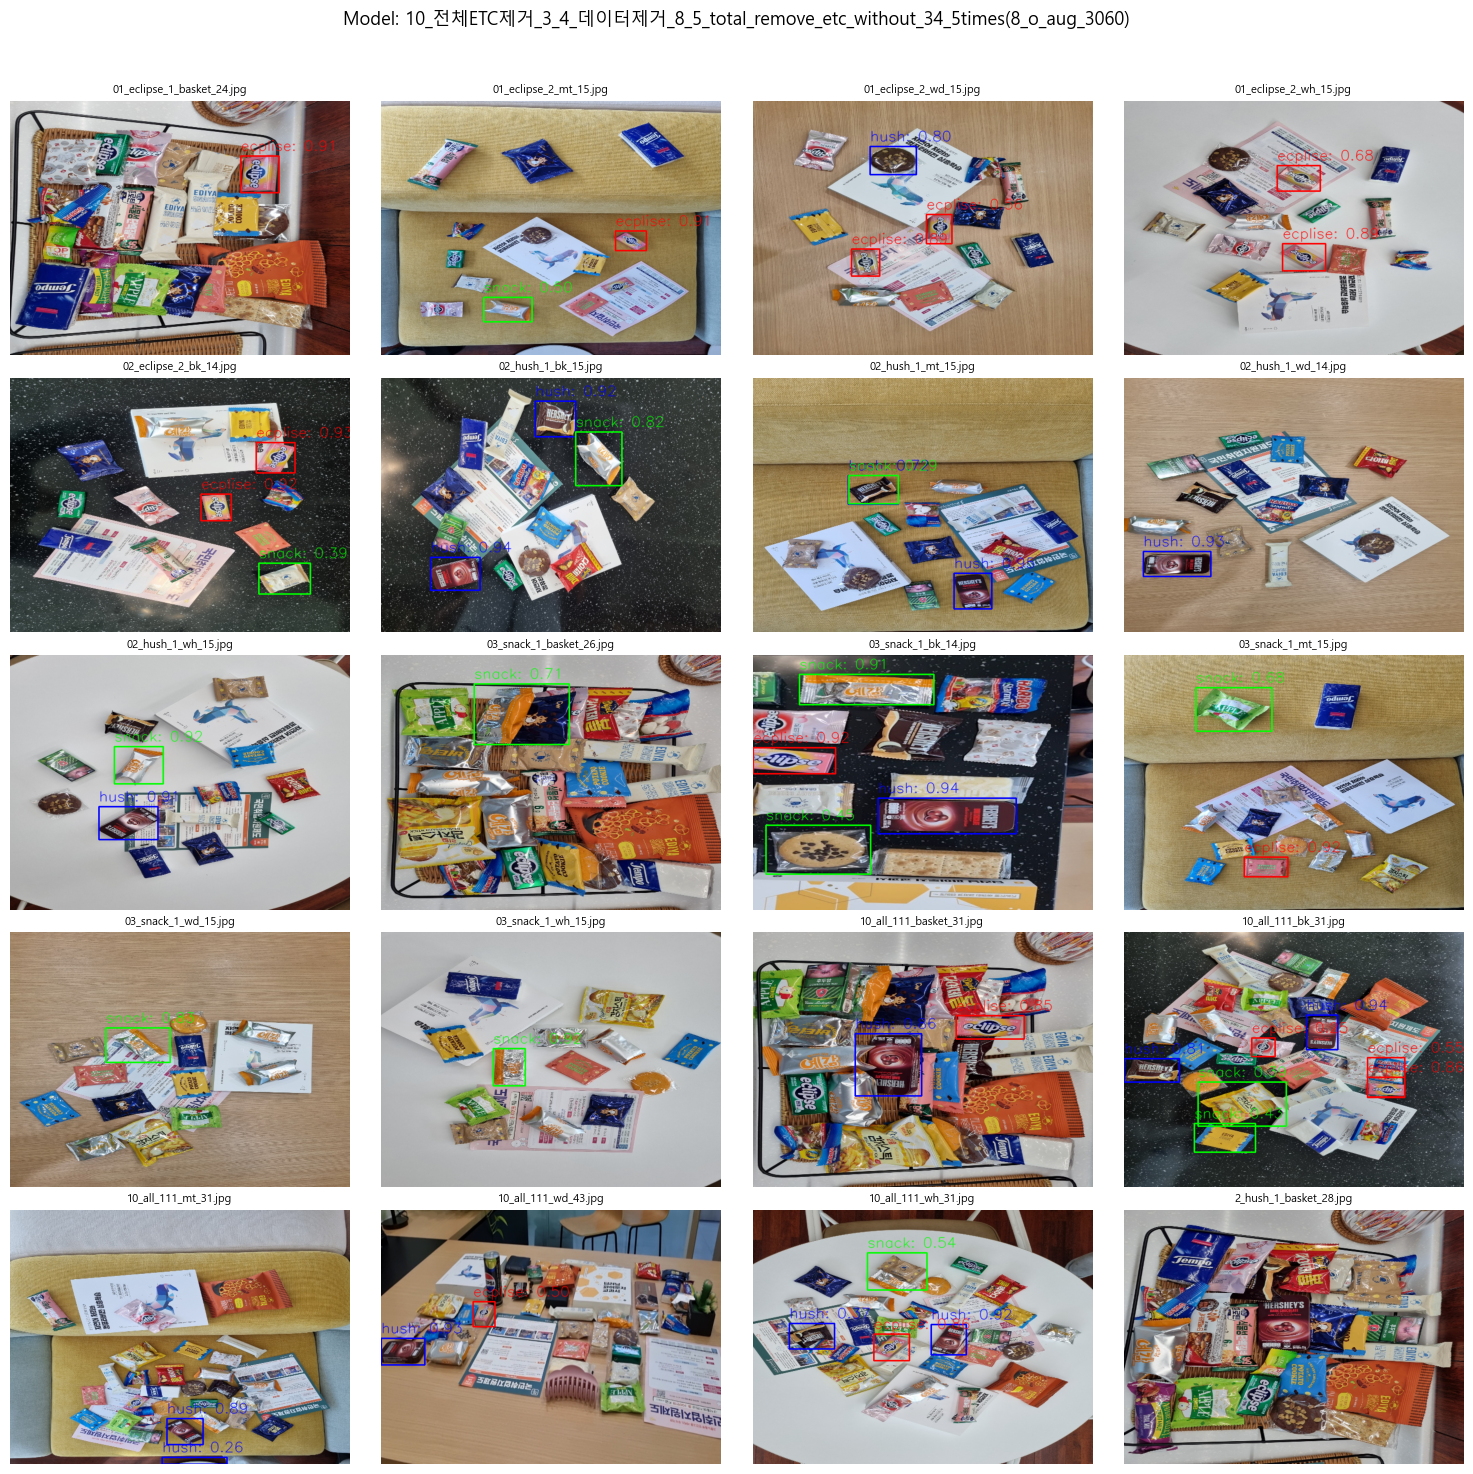

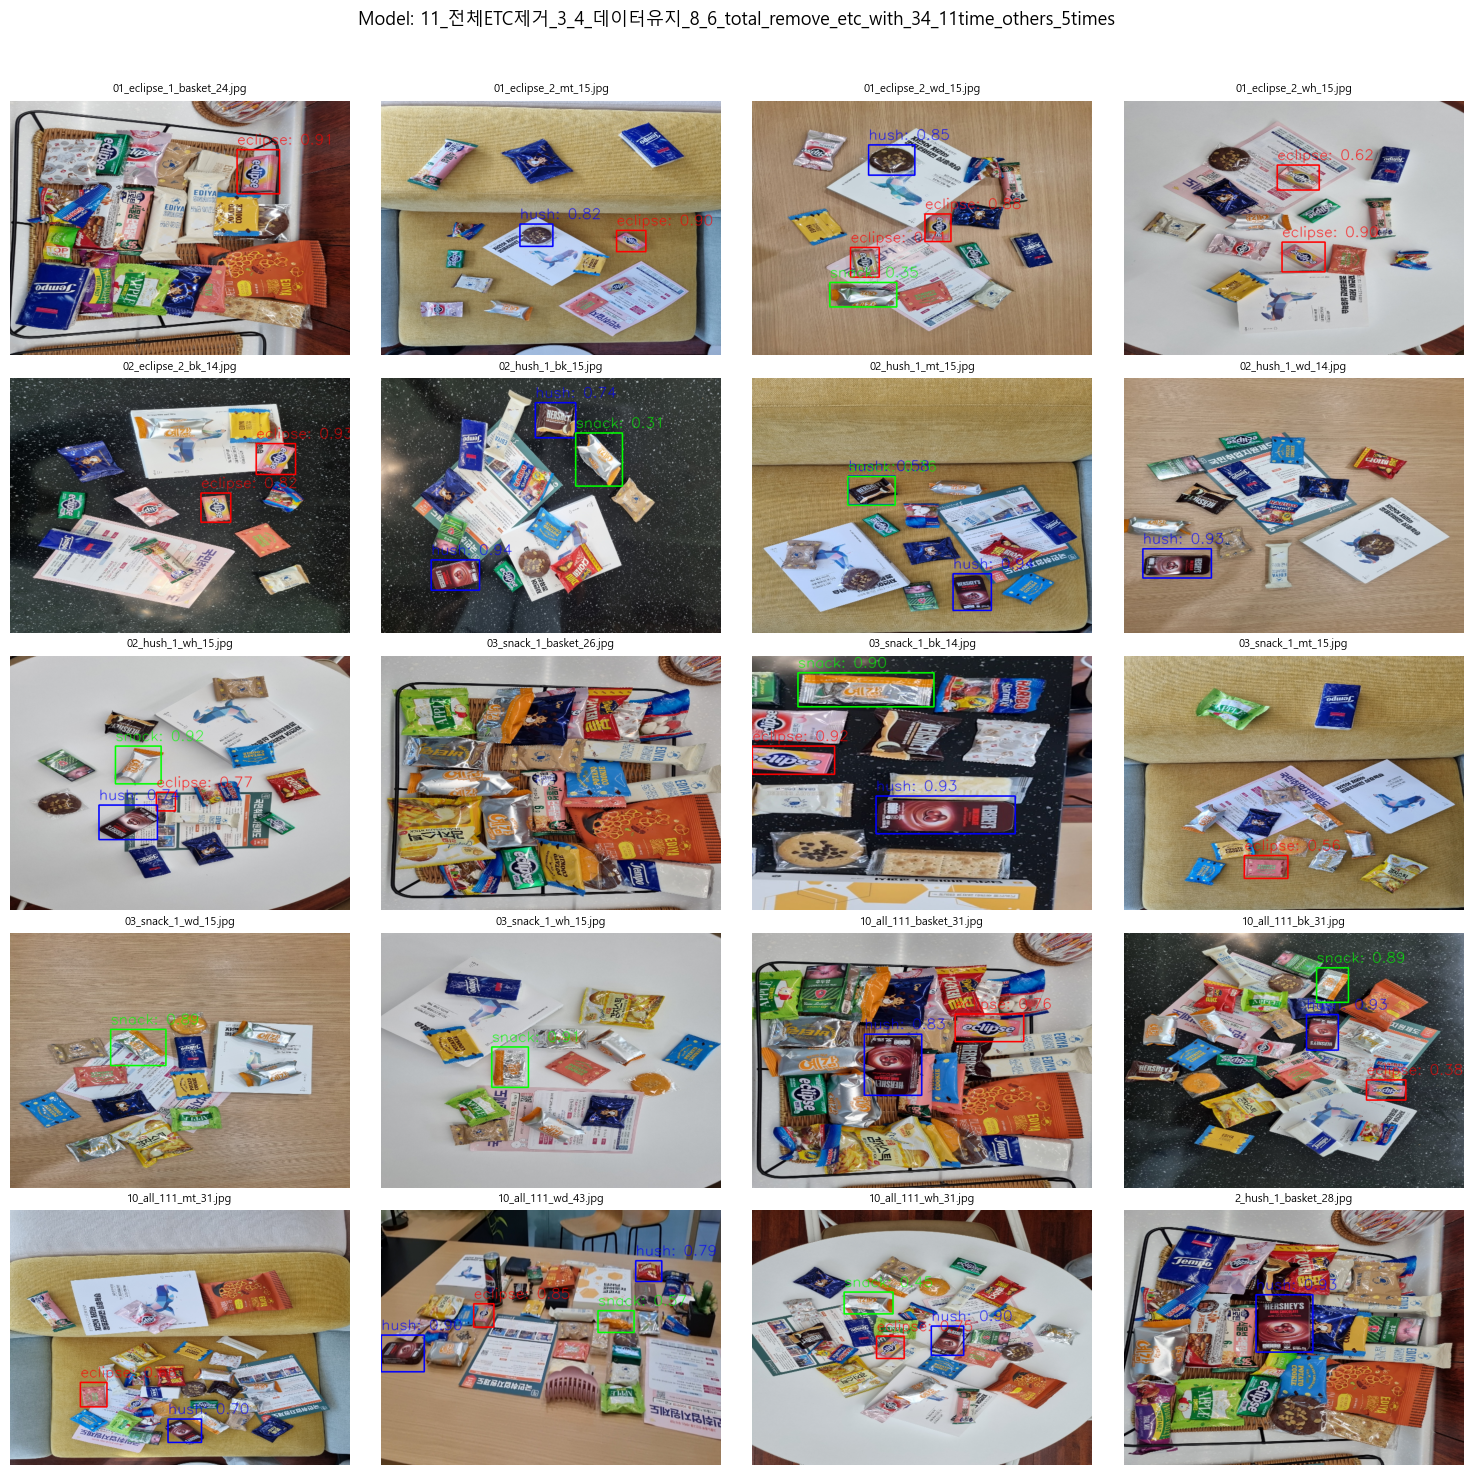

In [3]:
import os
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO

# 1. 여러 하위 폴더에서 best.pt 모델을 가져오기
model_folder = 'best_pt'  # 모델들이 담긴 상위 폴더 경로
model_paths = [os.path.join(model_folder, subfolder, 'best.pt') for subfolder in os.listdir(model_folder) if os.path.isdir(os.path.join(model_folder, subfolder))]

# 2. 테스트할 이미지 파일 경로 정의
image_folder = 'test_numbering_image'
image_files = [f for f in os.listdir(image_folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

# 3. 각 모델별 예측 결과를 저장할 리스트
all_models_processed_images = []

# 4. 각 모델별로 예측 수행
for model_path in model_paths:
    if os.path.exists(model_path):
        try:
            # 모델 불러오기
            model = YOLO(model_path)
            model_name = os.path.basename(os.path.dirname(model_path))  # 모델이 있는 폴더 이름을 모델 이름으로 사용

            # 4개의 클래스에 대한 고정된 색상 설정 (BGR 형식)
            class_colors = {
                0: (0, 0, 255),    # 빨강
                1: (255, 0, 0),    # 파랑
                2: (0, 255, 0),    # 초록
                3: (0, 255, 255)   # 노랑
            }

            # 모델의 예측 결과를 저장할 리스트
            processed_images = []

            # 각 이미지에 대해 예측 수행
            for image_file in image_files:
                image_path = os.path.join(image_folder, image_file)
                image = cv2.imread(image_path)
                if image is None:
                    print(f"이미지를 불러오지 못했습니다: {image_file}")
                    continue

                resized_image = cv2.resize(image, (640, 480))  # 이미지 크기 조정

                # 모델 예측 수행
                results = model(resized_image)

                # 예측 결과에 따라 바운딩 박스와 텍스트 추가
                for result in results:
                    for box in result.boxes:
                        # 바운딩 박스 좌표 추출 및 정수 변환
                        x_min, y_min, x_max, y_max = map(int, box.xyxy[0])

                        # 레이블과 신뢰도 점수 추출
                        confidence = box.conf.item()
                        label = int(box.cls.item())
                        label_name = model.names[label]  # 클래스 이름 가져오기
                        color = class_colors.get(label, (255, 255, 255))  # 해당 클래스의 색상 가져오기, 없으면 흰색

                        # OpenCV로 바운딩 박스와 텍스트 추가 (클래스별 색상 적용)
                        cv2.rectangle(resized_image, (x_min, y_min), (x_max, y_max), color, 2)
                        text = f'{label_name}: {confidence:.2f}'
                        cv2.putText(resized_image, text, (x_min, y_min - 10),
                                    cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 1, cv2.LINE_AA)

                # RGB로 변환 후 처리된 이미지를 저장
                processed_images.append((cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB), f"{model_name} - {image_file}"))

            # 모델별 처리된 이미지를 저장
            all_models_processed_images.append((model_name, processed_images))
        
        except Exception as e:
            print(f"모델 {model_name} 처리 중 오류 발생: {e}")

# 5. 여러 이미지를 n행 × n열 그리드로 시각화하는 함수 정의
def plot_grid(images_with_titles, rows, cols, grid_title):
    """이미지를 n행 × n열 그리드로 표시, 그리드 제목 포함"""
    fig, axes = plt.subplots(rows, cols, figsize=(15, 15))  # 그리드 생성

    # 각 이미지에 대해 축 설정
    for i, (img, title) in enumerate(images_with_titles):
        ax = axes.flatten()[i] if i < rows * cols else None
        new_title = title.split(' ')[-1]
        if ax:
            ax.imshow(img)  # 이미지 표시
            ax.set_title(new_title, fontsize=8)  # 파일명
            ax.axis('off')  # 축 숨기기

    # 남은 축은 비활성화 (빈 공간 처리)
    for ax in axes.flatten()[len(images_with_titles):]:
        ax.axis('off')  # 빈 축 숨기기

    # 그리드 전체의 제목 설정
    fig.suptitle(grid_title, fontsize=13)
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # 제목 공간 확보
    plt.show()

# 6. 각 모델별로 그리드를 추가하여 시각화
for model_name, processed_images in all_models_processed_images:
    if not processed_images:
        print(f"모델 {model_name}에 대한 이미지가 없습니다.")
        continue

    total_images = len(processed_images)
    cols = 4  # 한 줄에 표시할 이미지 수
    rows = (total_images // cols) + 1 if total_images % cols != 0 else total_images // cols

    # 모델의 예측 결과를 그리드로 시각화, 그리드에 모델 이름을 제목으로 설정
    plot_grid(processed_images, rows=rows, cols=cols, grid_title=f"Model: {model_name}")
